❗Before starting, make sure the following files are in the same directory as your Jupyter notebook:
 - train_data.pgz
 - test_data.pgz
 - vocab_list.pgz
 - train_id.pgz
 
 You can download these files from `Sakai > Resources > HW1`.

# Homework 1: Ridge logistic regression
In this homework, the objective is to train a model for a **<span style='background :greenyellow'>binary classification** task. Specifically, the task is to classify movie reviews (submitted by users on IMDb) as either positive ("It was a great film!") or negative ("Absolute trash!").

### The dataset
Regarding the data, the reviews are *not* represented as raw text, but instead as word-frequency vectors. That is, in their raw form, each review is represented by a 1000-dimensional real-valued vector. (Note that we have a vocab list of 1000 words.) Given one "review" vector, each value within that vector is a normalized frequency (or count) of that word in the given review. 

Each word-frequency vector is paired with a label, either -1 (negative, bad) or 1 (positive, good).

### The model
You will implement a **<span style='background :greenyellow'>ridge-regularized logistic regression** model, trained by gradient ascent, to solve this binary classification problem. It will be trained on the provided training set. You'll try out different values for the regularization parameter (or "ridge term"), and report the corresponding accuracies on the validation set.

Once the model is trained to satisfaction, you will evaluate the model's performance on the test set, and report which vocab words were the most "confusing" to the model for a given review, that is, words that lead to that review being misclassified. 

## Import libraries and load dataset.

In [34]:
import matplotlib.pyplot as plt   
import gzip
import numpy as np
%matplotlib inline

import time
import urllib
import os.path
import sys

try:
    import cPickle as pickle
    kwargs = {}
except:
    import _pickle as pickle
    kwargs = {'encoding':'bytes'}
    
versionName = sys.version_info
if versionName[0] == 2:
    import urllib as U
elif versionName[0] == 3:
    import urllib.request as U

In [35]:
%%time

train_data, train_label = pickle.load( gzip.open( "train_data.pgz", "rb" ), **kwargs )
test_data = pickle.load( gzip.open( "test_data.pgz", "rb" ),**kwargs )
vocab_list = pickle.load( gzip.open( "vocab_list.pgz", "rb" ),**kwargs )

train_label = np.asarray(train_label)

trainData = train_data[:10000, :]
validData = train_data[10000:15000, :]
trainLabel = train_label[:10000]
validLabel = train_label[10000:15000]
testData = test_data[:10000, :]

CPU times: total: 1.55 s
Wall time: 3.48 s


# 0. Relevant and super important definitions

Data are given as $D = {(\mathbf{x}_i, y_i):, i = 1...n}$, where $y_i \in \{-1, +1\}$, and $\mathbf{x}_i \in R^p$. </br>
There are $n$ samples. Each sample has $p$ features. </br>

For logistic regression, 
* We have model parameters: $\mathbf{w} \in R^p$ for the weight term, and $b$ for the bias term.
<br>
* For a sample $x$ and its label $y$, we have the following probability function: 

   $\large p(y|\mathbf{x}, \mathbf{w}, b) = \frac{1}{1+exp\{-y(\mathbf{w} \cdot \mathbf{x} + b)\}}$ 
<br>
* We will include the bias term in the weight vector. Therefore, our feature and weight vectors will be defined as follows: 

   $\large x' = \begin{bmatrix} 1\\ x \end{bmatrix}$ and $\large \mathbf{w}' =  \begin{bmatrix} b\\ \mathbf{w} \end{bmatrix}$
<br>

    * But for brevity, we will still use notations $x, \mathbf{w}$ as $x', \mathbf{w}'$. 
    * The first entry of the vector $\mathbf{w}'$ is the bias term and the remaining entries are feature weights. In code, you can use `w[0]` to access the bias term and `w[1:]` to access the feature weights. 
    * We do this concatenation for you in the code block below.

In [36]:
# Concatenation such that the first feature becomes the bias term.
train_data_pad = np.concatenate((np.ones((trainData.shape[0], 1)), trainData), axis=1)
test_data_pad = np.concatenate((np.ones((testData.shape[0], 1)), testData), axis=1)
valid_data_pad = np.concatenate((np.ones((validData.shape[0], 1)), validData), axis=1)

# I. Likelihood expression

1) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Write out the likelihood function, $\mathcal{L}(\mathbf{w})$, of logistic regression. </font> (Your variables will not be the ones used in lecture. Refer back to the definitions given in Section 0.)
<br><br>

<font color=blue>  
    
$$
\mathcal{L}(\mathbf{w}) = \prod_{i=1}^{N}  p(y_{i}|\mathbf{x_{i}}, \mathbf{w}) =  \prod_{i=1}^{N} \frac{1}{1+exp\{-y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\}}
$$

    
2) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Write out the log-likelihood function, $\mathcal{L}\mathcal{L}(\mathbf{w})$. <font color=black> (i.e. Take the log of your answer to Question 1.) 
<br><br>
    
<font color=blue>   
    
$$ 
\mathcal{L}\mathcal{L}(\mathbf{w}) = -\sum_i \log(1+exp\{-y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\})
$$
    
    
    
3) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Add on a ridge penalty term to the log-likelihood function. <font color=black> The weight of the ridge penalty is $\alpha$. <br> 
(*Hint: Do not include $w_0$ in the ridge term!!*)
<br><br>
    
<font color=blue>   
    
$$    
P\mathcal{L}\mathcal{L}(\mathbf{w}) = -\sum_i \log(1+exp\{-y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\})  - \frac{\alpha}{2}\sum_{j=1}^{p} w_{j}^2 
$$
    
    
4) **<span style='background :yellow'>(1pt)</span>** <font color=blue> In the cell below, replace the ellipses (three of them) with code to complete `loglikelihood`, a function that computes the ridge-regularized log-likelihood for `w` given the data `X`,.

In [37]:
def loglikelihood(w, X, y, alpha): 
    # w is a vector, X is a n*p matrix, and y is a vector.
    tmp = 1. + np.exp( -y * (X.dot(w)) )                           ## FILL-IN-THE-BLANK ## 
    return -np.sum( np.log(tmp) ) - (alpha/2.)*np.sum( w[1:]**2 )   ## FILL-IN-THE-BLANK ## 

In [38]:
# Small test to check that function works.
np.random.seed(1)
X = np.random.randn(2,3)
y = np.array([1,-1])
w = np.ones(3)
w[[1]] = -1

ur_answer = loglikelihood(w, X, y, 1)
expected =  -np.log(1+np.exp(-1*(X[0,0]-X[0,1]+X[0,2]))) \
- np.log(1+np.exp(1*(X[1,0]-X[1,1]+X[1,2]))) -1/2.*np.sum(w[1:]**2)

did_u_pass = (ur_answer==expected)

print(f"Passed test? {did_u_pass}")

Passed test? True


# II. Gradient ascent derivation

In order to optimize the log-likelihood function, we want to take its derivative w.r.t. each parameter in $\mathbf{w}$, and then update $\mathbf{w}$ according to the direction of the resultant gradient.

5) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Write out the derivative of the ridge-penalized log-likelihood function (your answer to Question 3) w.r.t. **both $w_0$ and $w_j$**. </font> (*Hint: Remember that the bias term is $w_0$. Treat it separately from the rest of $w_j$, $j\in\{1,...,p\}$!!*)
<br><br>
    
<font color=blue>   
    
$$
\frac{\partial P\mathcal{L}\mathcal{L}(\mathbf{w})}{ \partial w_0} = \sum_i \frac{y_{i}}{1+exp\{y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\}} \\ 
\\
\frac{\partial P\mathcal{L}\mathcal{L}(\mathbf{w})}{ \partial w_j} = \sum_i \frac{y_{i}x_{ij}}{1+exp\{y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\}}  - \alpha w_{j}, j>0 \\
$$
    
    
6) **<span style='background :yellow'>(1pt)</span>**  Write out the gradient of the log-likelihood function.
<br><br>
    
<font color=blue>   
    
$$ 
\nabla P\mathcal{L}\mathcal{L}(\mathbf{w}) = \sum_i \frac{y_{i}}{1+exp\{y_{i}(\mathbf{w} \cdot \mathbf{x_{i}})\}} \begin{bmatrix}  1\\ x_{i1}\\ \vdots \\ x_{ip} \end{bmatrix} - \begin{bmatrix}  0\\  \alpha w_{1}\\ \vdots \\ \alpha w_{p} \end{bmatrix}
$$
    
    
7) **<span style='background :yellow'>(1pt)</span>**  In the cell below, replace the ellipses (six of them) to update the `loglikelihood`  function such that it returns both the loglikelihood and the gradient.

In [39]:
def loglikelihood(w, X, y, alpha): 
    tmp = 1. + np.exp(-y * np.dot(X,w) )        ## FILL-IN-THE-BLANK ## 
    prob = 1./(1. + np.exp(y*np.dot(X,w)))
    X = X.T 
    gradVal = np.dot(X, y*prob)       ## FILL-IN-THE-BLANK ## 
    penalty = alpha/2. * np.sum(w[1:]**2)  ## FILL-IN-THE-BLANK ## 
    gradPenalty = -alpha * w              ## FILL-IN-THE-BLANK ## 
    gradPenalty[0] = 0            ## FILL-IN-THE-BLANK ## 
    return -np.sum( np.log( tmp ) ) - penalty, gradVal + gradPenalty

We will check your `loglikelihood` function by comparing the gradient it computes to numerical answers.
<br>
<font color=blue>
Run the code below. If you pass, you get the point for Question 7.

In [40]:
def grad_check(f,xy0,delta=1e-6,tolerance=1e-7):
    f0,g0 = f(xy0)
    p = len(xy0)
    finite_diff = np.zeros(p)
    gradient_correct = True
    for i in range(p):
        xy1 = np.copy(xy0)
        xy2 = np.copy(xy0)
        xy1[i] = xy1[i] - 0.5*delta
        xy2[i] = xy2[i] + 0.5*delta
        f1,_ = f(xy1)
        f2,_ = f(xy2)
        finite_diff = (f2 - f1)/(delta)
        if (abs(finite_diff - g0[i])>tolerance):
            print("Broken partial",i," Finite Diff: ",
                  finite_diff," Partial: ",g0[i])
            gradient_correct = False
    return gradient_correct

w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0
g = lambda xy0: loglikelihood(xy0, X=train_data_pad[:,:15], y=trainLabel, alpha=1)

did_u_pass = grad_check( g, w_init[:15], delta=1e-6, tolerance=1e-5 )

print(f"Passed test? {did_u_pass}")

Passed test? True


# III. Gradient ascent fine-tuning
We provide you with the gradient ascent function in the cell below. (ur welcome)

In [41]:
def gradient_ascent(f,x,init_step,iterations):  
    f_val,grad = f(x)                           # compute function value and gradient 
    f_vals = [f_val]
    for it in range(iterations):                # iterate for a fixed number of iterations
        done = False                            # initial condition for done
        line_search_it = 0                      # how many times we tried to shrink the step
        step = init_step                        # reset step size to the initial size
        while not done and line_search_it<100:  # are we done yet?
            new_x = x + step*grad               # take a step along the gradient
            new_f_val,new_grad = f(new_x)       # evaluate function value and gradient
            if new_f_val<f_val:                 # did we go too far?
                step = step*0.95                # if so, shrink the step-size
                line_search_it += 1             # how many times did we shrank the step
            else:
                done = True                     # better than the last x, so we move on
        
        if not done:                            # did not find right step size
            print("Line Search failed.")
        else:
            f_val = new_f_val                   # ah, we are ok, accept the new x
            x = new_x
            grad = new_grad
            f_vals.append(f_val)
        plt.plot(f_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Function value')
    return f_val, x

np.random.seed(12345)
w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0

def optimizeFn( init_step, iterations, alpha, w):
    g = lambda xy0: loglikelihood(xy0, train_data_pad, trainLabel, alpha)
    f_val, update_w = gradient_ascent( g, w, init_step, iterations )
    return f_val, update_w

8) **<span style='background :yellow'>(1pt)</span>** <font color=blue> In the cell below, try three different values (1e-5, 1e-6, and 1e-7) for the `init_step` variable. Then, in the provided "ANSWER" cell, report the final regularized log-likelihood for each of the three `init_step` values below.

CPU times: total: 46.9 ms
Wall time: 162 ms


-3033.038248915222

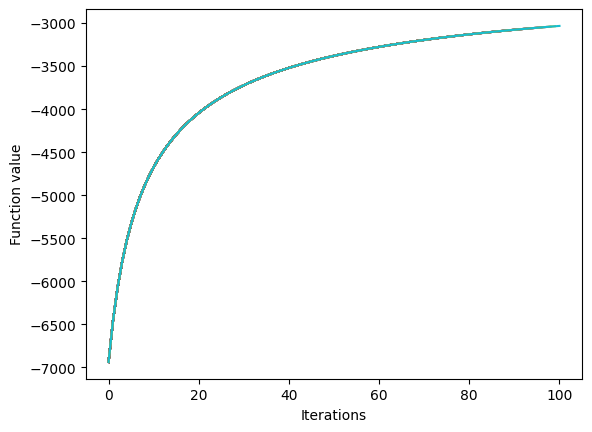

In [42]:
%%time
f_val, update_w = optimizeFn( init_step = 1e-5, iterations=100, alpha=0, w = w_init)
f_val

#### *ANSWER to Q8:* 
<font color=blue>
    
* Final $P\mathcal{L}\mathcal{L}$ for 1e-5 = -3033.038248915222
* Final $P\mathcal{L}\mathcal{L}$ for 1e-6 = -4707.155301132124
* Final $P\mathcal{L}\mathcal{L}$ for 1e-7 = -6477.459028629964

# IV. Prediction, hyperparameter tuning, and evaluation

To evaluate the performance of our model we need to have a prediction function. This function will use our trained model to predict whether reviews are positive or negative.

9) **<span style='background :yellow'>(1pt)</span>** <font color=blue> In the cell below, replace the ellipses (three of them) with code to complete the `prediction` function. The inputs are (1) feature weights and (2) the feature matrix. The return value is a vector of predicted labels.

In [43]:
def prediction(w, validData ):
    prob = 1./(1+np.exp( -np.dot(validData, w) ))         ## FILL-IN-THE-BLANK ## 
    res = np.zeros(validData.shape[0])
    res[prob>=0.5] = 1                ## FILL-IN-THE-BLANK ## 
    res[prob<0.5] = -1                 ## FILL-IN-THE-BLANK ## 
    return res

10) **<span style='background :yellow'>(1pt)</span>** <font color=blue> In the cell below, try different values for the `alpha` variable (1000, 2000, 3000). Then, in the provided "ANSWER" cell, report which of the three produces the model that has the best accuracy on the validation set.

Accuracy on the validation set: 84.74%


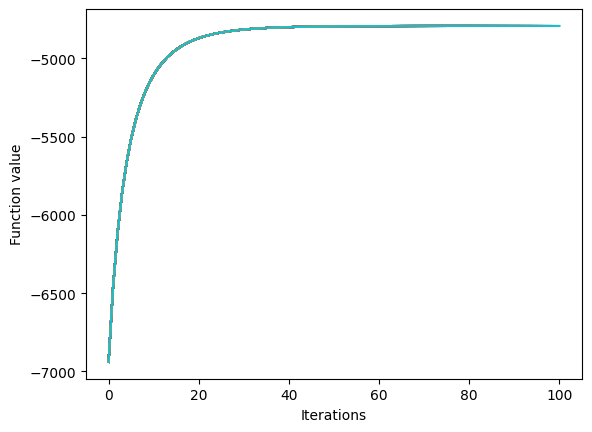

In [44]:
f_val, update_w=optimizeFn( init_step = 1e-5, iterations=100, alpha=3000, w=w_init)
pred = prediction(update_w, valid_data_pad)
print( 'Accuracy on the validation set: {:.2f}%'.format( 100.*np.mean(pred==validLabel)) )

#### *ANSWER to Q10:* 
<font color=blue> 
The best alpha is 3000, and the accuracy of this alpha is 84.74%

11) **<span style='background :yellow'>(1pt)</span>** <font color=blue> We would like to know which samples in the validation set are misclassifed with high probability (that is, >90%).
    
<font color=blue>To accomplish this you must replace the ellipses with code, in the cell below, to implement `computeProb`. Additionally, you must write code to retrieve indices of samples that are misclassified; these indices are designated as `wrong_idx_high` in the cell below.
      
<font color=blue>After writing your code, report the indices for all samples that result in high-confidence misclassifcations in the provided "ANSWER" cell. 

In [50]:
# Command to get the samples that are predicted wrong
wrong_idx = np.nonzero( validLabel != pred )[0]

# Function to compute probability
def computeProb(w, validData ):
    prob = 1./(1+np.exp( -np.dot(validData, w)) )  ## FILL-IN-THE-BLANK ## 
    return prob

# Get samples that are classified wrong and with probabilites > 0.9
probs = computeProb(update_w, valid_data_pad)
wrong_idx_high = wrong_idx[(probs[wrong_idx] >= 0.9) | (probs[wrong_idx] <= 0.1)]            ## FILL-IN-THE-BLANK ## 
print(wrong_idx_high)

[  95  443  591 1473 2027 2257 3204]


#### *ANSWER to Q11:* 
<font color=blue>
    
The indices corresponding to high-confidence misclassified samples are 
95  443  591 1473 2027 2257 3204 

12) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Choose one of the misclassified indices from above and set it equal to `sampleIdx` in the cell below. Then in the provided "ANSWER" cell, report the words (entries in `vocab_list` associated with that feature) that cause the selected sample  to be misclassified. </font> (Just fyi: Weight $w[i]$ correponds to word `vocab_list[i-1]`, because we included bias term in $w$.)

In [13]:
sampleIdx = 591

# This function returns a list of top 10 words that influence the prediction.
def getMostImportantFeatures( sampleIdx, validData, update_w, vocab_list ):
    confusedList = []
    intensity = validData[[sampleIdx],:]*update_w
    tmp = np.argsort( np.abs(intensity[0,:]) )[::-1]
    for j in np.arange(10):
        confusedList.append(vocab_list[tmp[j]-1])
    return confusedList

confusedList = getMostImportantFeatures( sampleIdx, valid_data_pad, update_w, vocab_list)
print(confusedList)

['bad', 'dumb', 'silly', 'fun', 'awful', 'truly', 'action', 'dialog', 'nothing', 'money']


#### *ANSWER to Q12:* 
<font color=blue>
    
The "confusing" words for the chosen review are 'please', 'atmosphere', 'dull', 'poor', 'excellent', 'bad', 'point', 'job', 'make', 'silly'

As a sanity check, you can read the review (by going to the URL printed below) and check if it is hard to classify.

In [14]:
train_id = pickle.load( gzip.open( "train_id.pgz", "rb" ) )
valid_id = train_id[10000:15000]

fileName = valid_id[sampleIdx]
fileUrl = "https://wwwx.cs.unc.edu/Courses/comp755-f18/hw1/reviews/" + fileName + '.txt'
print(fileUrl)

https://wwwx.cs.unc.edu/Courses/comp755-f18/hw1/reviews/11026_7.txt
